In [17]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

## Проблемы каллибровки уверенности классификаторов

Калибровка нужна для:
1. Правильного понимания, насколько результатам алгоритма можно доверять. Это важно при интерпретации моделей, а также для принятия решений о внедрении систем ML и анализа их работы.
2. Для более точного решения задач ML в целом, ведь уверенности часто используются другими алгоритмами, например в языковых моделях (language models) при генерации текстов используются вероятности появления отдельных токенов (например, при применении лучевого поиска – beam search).
3. Для настройки на скоринговых моделей.

In [18]:
X, y = make_classification(
    n_samples = 12000, # количество сэмплов
    n_features = 30, # количество функций
    n_informative = 20, # количество информ. функций
    n_redundant = 10, # количество избыточных функций
    weights = [.10, .1], # пропорции сэмплов для каждого класса
    random_state = 42) # генерация случайных чисел

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [20]:
from sklearn.svm import LinearSVC
class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [21]:
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = NaivelyCalibratedLinearSVC(C=1.0, dual="auto")
rfc = RandomForestClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
]

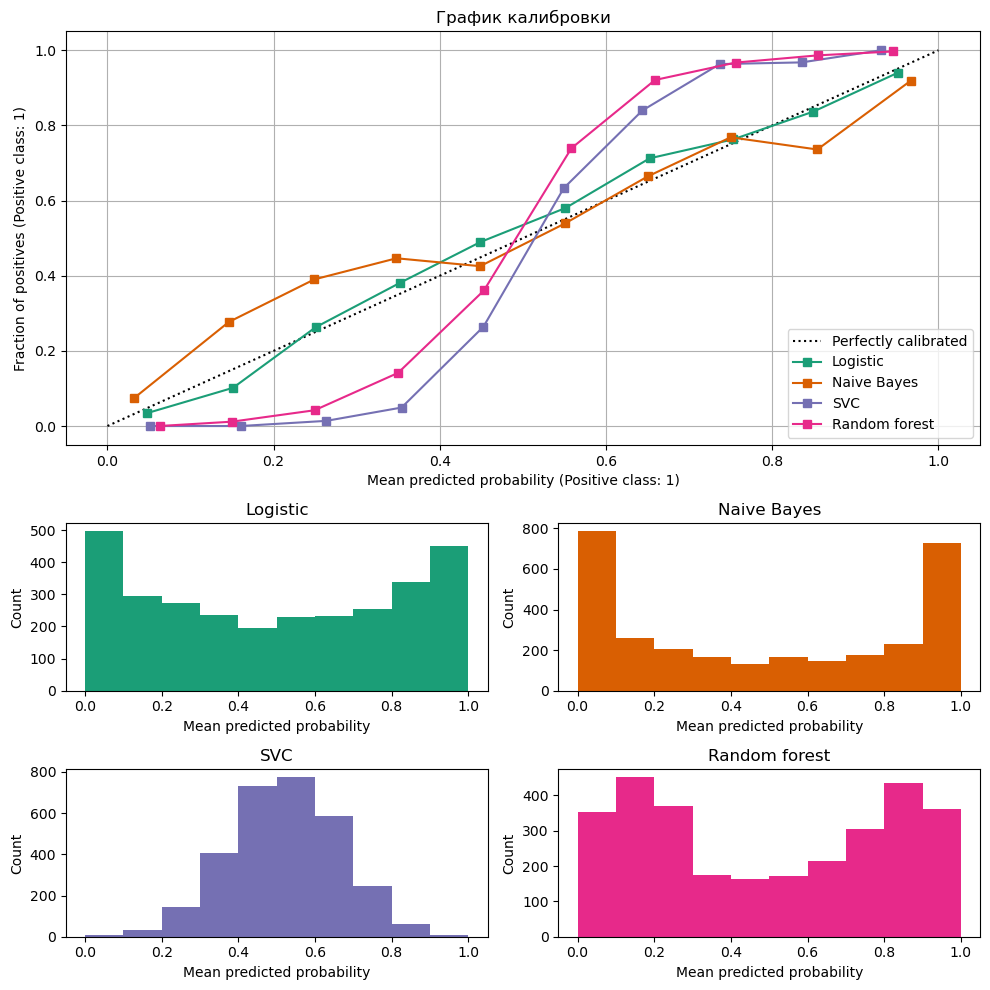

In [22]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i)
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("График калибровки")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

Калибровка классификатора состоит из подгонки регрессии (называемого калибратором), который сопоставляет выходные данные классификатора (заданные `decision_function` или `predict_proba`) с откалиброванной вероятностью в диапазон $\{0, 1\}$.

Как решить данную проблему? В `sklearn` есть два вида калибровки:
1. Параметрическая калибровка Платта (Platt calibration) `method="sigmoid"`
2. Непараметрический метод – изотонная регрессия (Isotonic Regression) `method="isotonic"`

По идее калибровка не влияет на показатели ранжирования, такие как ROC-AUC. Тем не менее, эти метрики могут отличаться после калибровки при использовании метода - изотоническая регрессия, поскольку изотоническая регрессия вводит связи в прогнозируемые вероятности. 

Это можно рассматривать как неопределенность модельных прогнозов. В случае, если вы строго хотите сохранить рейтинг и, следовательно, оценки AUC, используйте `method="sigmoid"`, который является строго монотонным преобразованием и, таким образом, сохраняет рейтинг.